Written by Bart Smeets (2022)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

# User Interface

In [2]:
# Set Directory
INITIAL_PATH = os.environ.get('THESIS_DATA')
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)

DIRECTORY = filedialog.askdirectory(initialdir=INITIAL_PATH, title='Select Data Director')
os.chdir(DIRECTORY)    # Change working directory
root.destroy()


# Load parameter data (if existing)
if os.path.exists('OUTPUT_BEAM_PROFILE.txt'):
    PARAMETER_DATA = np.loadtxt('OUTPUT_BEAM_PROFILE.txt', skiprows=1, dtype=object)
else:
    PARAMETER_DATA = np.ndarray((4,4), dtype=object)
    PARAMETER_DATA[2,1] = '663.4131'
    PARAMETER_DATA[0,1] = '12.157123' 

In [3]:
# Create Window
root = tk.Tk()
root.geometry('750x300')
root.title('User Input')
root.resizable(0,0)
root.attributes('-topmost', True)

# Rayleigh length
## Create storage object and assign initial value
zR = tk.StringVar(value = str(PARAMETER_DATA[3,1]))
## Create labels
zR_label = ttk.Label(root, text=r'Rayleigh length:')
zR_unit_label = ttk.Label(root, text='um')
## Place labels in window
zR_label.grid(column=0, row=0, sticky=tk.W, padx=5, pady=5)
zR_unit_label.grid(column=2, row=0, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
zR_entry = tk.Entry(root, textvariable=zR)
zR_entry.grid(column=1, row=0, sticky=tk.E, padx=5, pady=5)

# Waist
## Create storage object and assign initial value
w0 = tk.StringVar(value = str(PARAMETER_DATA[0,1]))
## Create labels
w0_label = ttk.Label(root, text=r'Beam waist:')
w0_unit_label = ttk.Label(root, text='um')
## Place labels in window
w0_label.grid(column=0, row=1, sticky=tk.W, padx=5, pady=5)
w0_unit_label.grid(column=2, row=1, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
w0_entry = tk.Entry(root, textvariable=w0)
w0_entry.grid(column=1, row=1, sticky=tk.E, padx=5, pady=5)

# Linear absorption coefficient
## Create storage object and assign initial value
alpha0 = tk.StringVar(value = '0.0')
## Create and place label
alpha0_label = ttk.Label(root, text=r'Linear absorption coefficient:')
alpha0_label.grid(column=0, row=2, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
alpha0_entry = tk.Entry(root, textvariable=alpha0)
alpha0_entry.grid(column=1, row=2, sticky=tk.E, padx=5, pady=5)

# Laser power
## Create storage object and assign initial value
PLaser = tk.StringVar(value = '0.0')
## Create labels
PLaser_label = ttk.Label(root, text=r'Laser Power:')
PLaser_unit_label = ttk.Label(root, text='uW')
## Place labels in window
PLaser_label.grid(column=0, row=3, sticky=tk.W, padx=5, pady=5)
PLaser_unit_label.grid(column=2, row=3, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
PLaser_entry = tk.Entry(root, textvariable=PLaser)
PLaser_entry.grid(column=1, row=3, sticky=tk.E, padx=5, pady=5)

# Sample thickness
## Create storage object and assign initial value
L = tk.StringVar(value = '0.1')
## Create labels
L_label = ttk.Label(root, text=r'Sample thickness:')
L_unit_label = ttk.Label(root, text='cm')
## Place labels in window
L_label.grid(column=0, row=4, sticky=tk.W, padx=5, pady=5)
L_unit_label.grid(column=2, row=4, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
L_entry = tk.Entry(root, textvariable=L)
L_entry.grid(column=1, row=4, sticky=tk.E, padx=5, pady=5)

# File name directory
## Define browse function to assign to button
def browse(DIRECTORY):
    file.set(filedialog.askopenfilename(initialdir=DIRECTORY, title='Select Data File'))
    SHOW = file.get()
    show.set(SHOW[SHOW.rfind('/') + 1 :])    # Cut file-location at last / -> only show file name
    return  
## Create storage object and assign initial value
file = tk.StringVar(value='')
show = tk.StringVar(value='')
## Create and place labels
file_label = ttk.Label(root, text='Data File:')
file_label.grid(column=0, row=5, sticky=tk.W, padx=5, pady=5)
## Create and place entry field
file_entry = tk.Entry(root, textvariable=show, width = 75)
file_entry.grid(column=1, row=5, sticky=tk.E, padx=5, pady=5)
## Create and place browse button
file_browse= tk.Button(root, text='Browse', command=lambda: browse(DIRECTORY))
file_browse.grid(column=3, row=5, sticky=tk.E, padx=5, pady=5)

# Apply button
apply = tk.Button(root, text='Apply', command=lambda: root.destroy())
apply.grid(column=3, row=6, sticky=tk.E, padx=5, pady=5)

root.mainloop()

In [4]:
## Get values
ALPHA0 = float(alpha0.get())    # Unit mm-1
Z_R = float(zR.get()) * 1e-3    # Convert um to mm
W0 = float(w0.get()) * 1e-3    # Convert um to mm
P_LASER = float(PLaser.get())
P_LASER = P_LASER*1e-7/(6e-9)    # Wrong power meter conversion
L = float(L.get()) * 10   # Convert cm to mm

FILE_NAME = file.get()

# Load data

In [5]:
MEASUREMENT = np.loadtxt(FILE_NAME)

Z_DATA = MEASUREMENT[:, 0]
I_DATA = MEASUREMENT[:, 1]
SIGMA_I = MEASUREMENT[:,2]

I0 = 2 * P_LASER / (np.pi * W0**2)

# Plot rough data

<function matplotlib.pyplot.show(close=None, block=None)>

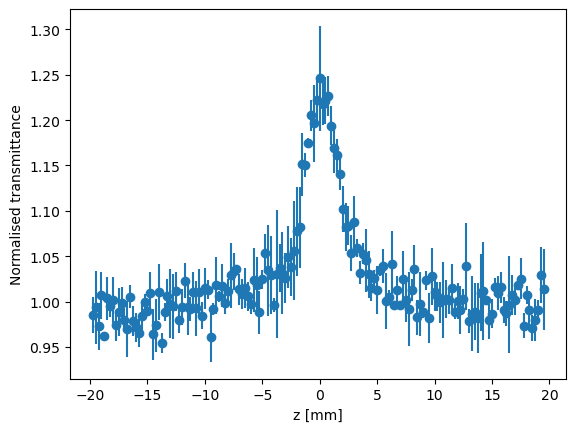

In [6]:
fig1 = plt.figure()

#plt.plot(z, I, 'o')
plt.errorbar(Z_DATA, I_DATA, SIGMA_I, fmt='o')

plt.xlabel('z [mm]')
plt.ylabel('Normalised transmittance')
plt.show

# Fit

## Define fitting model

### Absorption functions

In [7]:
# Beam intensity profile
def I(z, z0, I0, Z_R):
    return I0 / (1+((z-z0)/Z_R)**2)

# Differential intensity inside sample
def dI_dz(z, I, Is2, beta, ALPHA0):
    term1 = - ALPHA0 * I
    term2 = - beta / (1 + (I/Is2)) * I**2
    return term1 + term2

# Solve differential equation to find transmittance
def transmittance(z, z0, Is2, beta, L, ALPHA0, I0, Z_R):
    I_in = I(z, z0, I0, Z_R)    # Initial condition
    sol = solve_ivp(dI_dz, [0, L], I_in, args=(Is2, beta, ALPHA0), t_eval=[L])    # Runge-Kutta 45 method
    I_out = sol.y[:, 0]
    transmittance = (I_out / I_in) / (I_out[0] / I_in[0])
    return transmittance

### Chi2 minimising

In [8]:
# Chi2
def Chi2(data, z0, Is2, beta, L, ALPHA0, I0, Z_R):
    Z_DATA = data[:, 0]
    I_DATA = data[:, 1]
    
    ## Calculate transmittance
    weight = 1 / np.sqrt(1+((Z_DATA-z0)/Z_R)**2)    # Weigth function to add importance to focal point
    I_calc = transmittance(Z_DATA, z0, Is2, beta, L, ALPHA0, I0, Z_R)
    
    ## Calculate chi2
    if 0 in data[:, 2]:    # Poorly defined uncertainty
        chi2Vector = weight*(I_DATA - I_calc)**2
    else:
        chi2Vector = weight*(I_DATA - I_calc)**2 / np.average(data[:,2])**2
    return np.sum(chi2Vector)

# Chi2 minimalisation
def basinhopping(data, p0, L, ALPHA0, I0, Z_R, MODEL_PARAMETERS):
    ## Basin hopping parameters
    MAX_PERTURBATION, MAX_AGE, MAX_ITER, BOUNDS, T, MAX_JUMP, MAX_REJECT = MODEL_PARAMETERS
    
    fitting_model = lambda x: Chi2(data, x[0], x[1], x[2], L, ALPHA0, I0, Z_R)
    
    ## Set initial chi2
    popt = minimize(fitting_model, x0=p0, bounds=BOUNDS)
    pBest = pMin = popt.x
    chi2Prev = chi2Best = fitting_model(pMin)
    
    ## Start minimalisation process
    ### prepare iteration process
    niter = 0
    rejection = 0
    jump = 0
    bestAge = -1

    ### Iteration process
    while niter < MAX_ITER and bestAge < MAX_AGE:
        niter += 1
        bestAge += 1
        
        #### Monte Carlo Move
        pPerturbation = list(pMin)
        perturbation = np.random.uniform(1, MAX_PERTURBATION)    # Determine perturbation strength
        direction = np.random.choice(['decrease', 'increase'])    # Determine perturbation direction
        if direction == 'decrease':
            pPerturbation[1] = pMin[1] / perturbation
        else:
            pPerturbation[1] = pMin[1] * perturbation

        #### Minimise Chi2
        popt = minimize(fitting_model, x0=pPerturbation, bounds=BOUNDS)
        p_newMin = popt.x
        chi2 = fitting_model(p_newMin)
        
        #### Metropolis criterion
        ##### Accept perturbation
        ###### Jumping -> accept perturbation regardless of conditions
        if jump != 0:
            chi2Prev = chi2
            pMin = p_newMin
            jump += 1
            ## Check if result is overall best
            if chi2 < chi2Best:    
                pBest = p_newMin
                chi2Best = chi2
                bestAge = 0
            ## End condition for jumping
            if jump == MAX_JUMP:    
                jump = 0
        ###### Better chi2 than previous chi2
        elif chi2 < chi2Prev:    
            chi2Prev = chi2
            pMin = p_newMin
            rejection = 0
            ## Check if result is overall best            
            if chi2 < chi2Best:    
                pBest = p_newMin
                chi2Best = chi2
                bestAge = 0
        ###### Metropolis
        elif np.random.uniform(0,1) < np.exp(-(chi2 - chi2Prev)/T):
            chi2Prev = chi2
            pMin = p_newMin
            rejection = 0

        ##### Reject perturbation
        else:
            rejection += 1

        ##### Max Rejections achieved? -> Start jumping
        if rejection == MAX_REJECT:
            # Accept perturbation
            chi2Prev = chi2
            pMin = p_newMin
            rejection = 0
            jump += 1
    
    return pBest, chi2Best

## Run fitting model

In [9]:
# User Input
## Initial guess
Z0_0 = 18.7
I_S1_0 = 1e9
BETA_0 = 2e-10

## Model Parameters
N_RUNS = 10                        # Number of independent model calculations
MAX_PERTURBATION = 10              # Max perturbation size 
BOUNDS = ((0, 20), (1e4, None), (0, ALPHA0))    # Bounds of fitting-parameters: z0 and Is1
MAX_ITER = 10                      # Max number of iterations (stop-condition) (0 = classical algorithm)
MAX_AGE = 50                       # Max age of best Chi2 (stop-condition)
T = 0.8                            # Temperature (related to probability of a non optimal chi2 being taken as step)
MAX_JUMP = 5                       # Number of jumps permitted
MAX_REJECT = 5                     # Local minimum treshold

# Run
## Put Model Parameters in datastructure
MODEL_PARAMETERS = [MAX_PERTURBATION, MAX_AGE, MAX_ITER, BOUNDS, T, MAX_JUMP, MAX_REJECT]

## Progress bar
### Create window
root = tk.Tk()
root.geometry('300x120')
root.title('Progress bar')
root.resizable(0,0)
root.attributes('-topmost', True)
### Create and place progress bar
pb = ttk.Progressbar(root, orient='horizontal', mode='determinate', length='280')
pb.grid(column=0, row=0, columnspan=2, padx=10, pady=20)
### Ititialise progress bar
progress = 'Number of models computed: 0/' + str(N_RUNS) 
value_label = ttk.Label(root, text=progress)
value_label.grid(column=0, row=1, columnspan=2)
root.update()

## Run model
RUNS = np.ndarray((N_RUNS,5))    # Intialise data structure
fitting_model = lambda x: Chi2(MEASUREMENT, x[0], x[1], x[2], L, ALPHA0, I0, Z_R)
for i in range(N_RUNS):
    p0 = np.array([Z0_0, I_S1_0, BETA_0])    # Initial guess
    popt, chi2 = basinhopping(MEASUREMENT, p0, L, ALPHA0, I0, Z_R, MODEL_PARAMETERS)    # Run model

    ### Save results
    RUNS[i, 0]=popt[0]
    RUNS[i, 1]=popt[1]
    RUNS[i,2]=popt[2]
    RUNS[i,3] = chi2

    ### Update progress bar
    pb['value'] += 100 / N_RUNS    
    value_label.config(text= 'Number of models computed: ' + str(i+1) + '/' + str(N_RUNS))
    root.update()

## Find best results
CHI2_BEST = np.amin(RUNS[:,3])
index = np.where(RUNS[:,3]==CHI2_BEST)
P_BEST = RUNS[index, 0:3].reshape(-1)
root.destroy()


## Plot Results

### Best Result

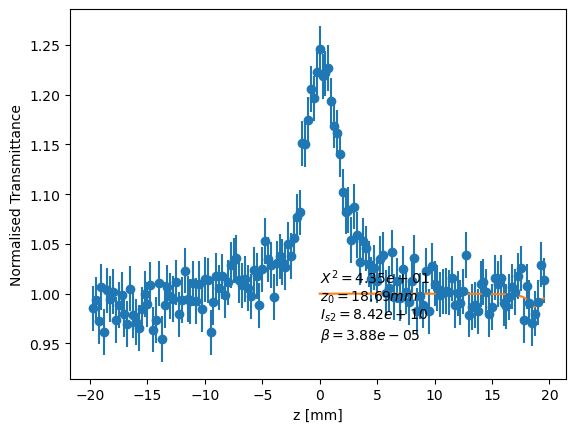

In [10]:
Z_PLOT = np.linspace(0, Z_DATA[-1], 100)
SIGMA_PLOT = np.ones(np.size(SIGMA_I)) * np.average(SIGMA_I)

textstr = '\n'.join((
    r'$X^{2}=%.2e$' % (CHI2_BEST, ),
    r'$z_{0}=%.2f mm$' % (P_BEST[0], ),
    r'$I_{s2}=%.2e$' % (P_BEST[1],),
    r'$\beta=%.2e$' % (P_BEST[2],)))

fig2 = plt.figure()
plt.errorbar(Z_DATA, I_DATA, SIGMA_PLOT, fmt= 'o')
plt.plot(Z_PLOT, transmittance(Z_PLOT, P_BEST[0], P_BEST[1], P_BEST[2], L, ALPHA0, I0, Z_R))
plt.text(0,np.amin(I_DATA), textstr)

plt.xlabel('z [mm]')
plt.ylabel('Normalised Transmittance')

plt.show()

### Plot all tries

<function matplotlib.pyplot.show(close=None, block=None)>

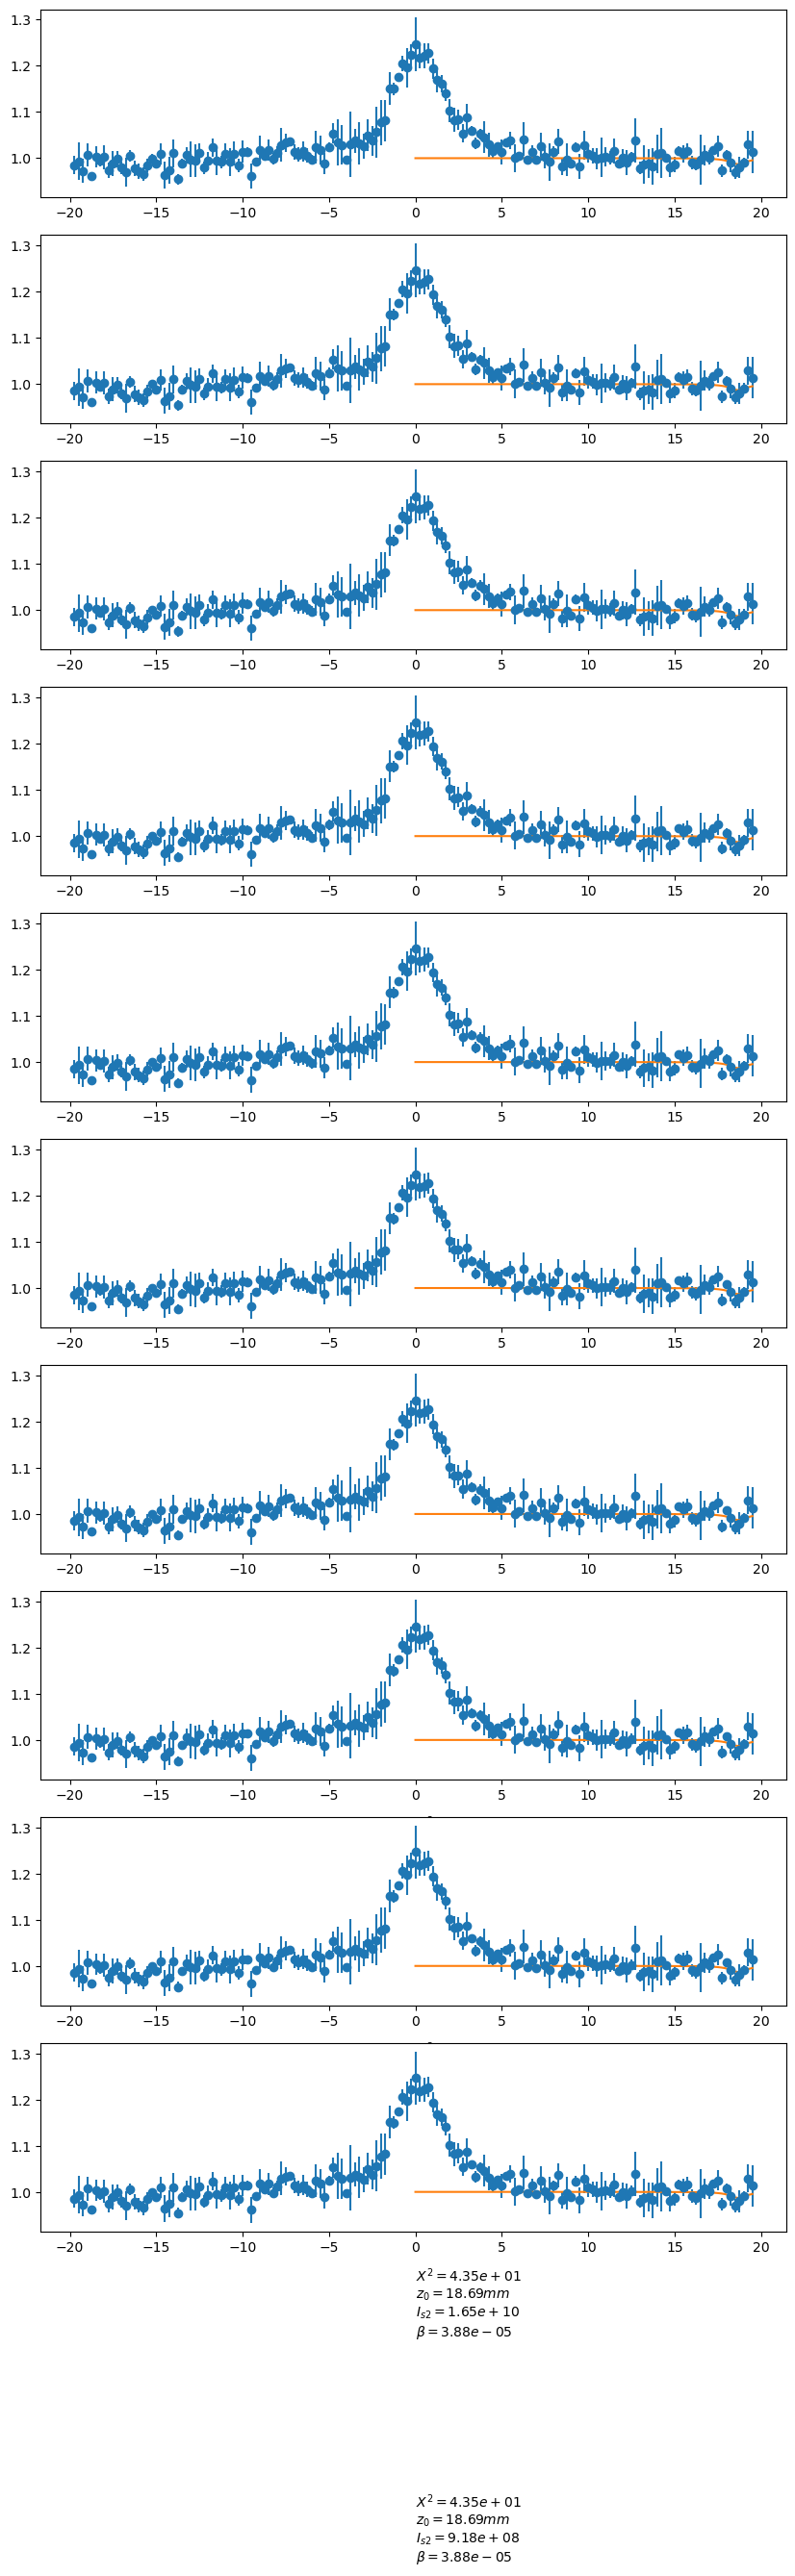

In [11]:
fig3, ax3 = plt.subplots(N_RUNS, 1, figsize=(10,3*N_RUNS))

for i in range(N_RUNS):
    z0_fit = RUNS[i,0]
    Is2_fit = RUNS[i,1]
    beta_fit = RUNS[i,2]
    
    textstr = '\n'.join((
    r'$X^{2}=%.2e$' % (RUNS[i,3], ),
    r'$z_{0}=%.2f mm$' % (z0_fit, ),
    r'$I_{s2}=%.2e$' % (Is2_fit,),
    r'$\beta=%.2e$' % (beta_fit,)))

    ax3[i].errorbar(Z_DATA, I_DATA, SIGMA_I, fmt='o')
    ax3[i].plot(Z_PLOT, transmittance(Z_PLOT, z0_fit, Is2_fit, beta_fit, L, ALPHA0, I0, Z_R))
    #ax3[i].plot(Z_PLOT, np.sqrt(I(Z_PLOT, z0_fit, I0, Z_R)/I0), ':')    # Weight function
    ax3[i].text(0,0.2, textstr)

plt.show

# Calculate errorbars

In [12]:
def Errorbar(P_BEST, CHI2_BEST, i, L, ALPHA0, I0, Z_R, data):
    # Initialise datastructure
    N_PARAMETERS = 3
    N_POINTS = len(data[:,0])
    STEP = 0.005
    lBound = [P_BEST[i], 0]
    rBound = [P_BEST[i], 0]
    lTest = np.array(P_BEST)
    rTest = np.array(P_BEST)

    # Determine chi2 region
    WEIGHT = np.sum(1/np.sqrt(1+((data[:,0]-P_BEST[0])/Z_R)**2)) / N_POINTS
    CHI2_COMPARISON = (N_POINTS - N_PARAMETERS) * WEIGHT + CHI2_BEST    # Degrees of freedom of model * average value of the weigth function

    # Error calculation
    newChi2 = 0
    iteration = 0
    while newChi2 < CHI2_COMPARISON and iteration != 100:
        iteration += 1
        rBound[0] = (1+STEP)*rBound[0]
        lBound[0] = (1-STEP)*lBound[0]
        rTest[i] = rBound[0]
        lTest[i] = lBound[0]

        rBound[1] = Chi2(data, rTest[0], rTest[1], rTest[2], L, ALPHA0, I0, Z_R)
        lBound[1] = Chi2(data, lTest[0], lTest[1], lTest[2], L, ALPHA0, I0, Z_R)
        newChi2 = max(lBound[1], rBound[1])

    # Choose appropriate error
    if rBound[1] > lBound[1]:
        errorbar = rBound[0]
        varyChi = rBound[1]
    else:
        errorbar = lBound[0]
        varyChi = lBound[1]

    return np.abs(errorbar-P_BEST[i]), varyChi

In [13]:
# Create data structure
SIGMA_P = np.zeros(3)
CHI2_SPAN = np.zeros(3)
SIGMA_P[0], CHI2_SPAN[0] = Errorbar(P_BEST, CHI2_BEST, 0, L, ALPHA0, I0, Z_R, MEASUREMENT)
SIGMA_P[1], CHI2_SPAN[1] = Errorbar(P_BEST, CHI2_BEST, 1, L, ALPHA0, I0, Z_R, MEASUREMENT)
SIGMA_P[2], CHI2_SPAN[2] = Errorbar(P_BEST, CHI2_BEST, 2, L, ALPHA0, I0, Z_R, MEASUREMENT)


# Generate and print output string
OUTPUT_STRING = textstr = '\n'.join((
    r'Fitting parameters',
    r'X2 = %.2f' % (CHI2_BEST, ),
    r'z0 = (%.2f +- %.2f) mm; X2 span: %.2f' % (P_BEST[0], SIGMA_P[0], CHI2_SPAN[0], ),
    r'Is2 = %.2e +- %.1e; X2 span: %.2f' % (P_BEST[1], SIGMA_P[1], CHI2_SPAN[1], ),
    r'beta = %.2e +- %.1e; X2 span: %.2f' % (P_BEST[2], SIGMA_P[2], CHI2_SPAN[2],)))
print(OUTPUT_STRING)

Fitting parameters
X2 = 43.54
z0 = (18.69 +- 4.72) mm; X2 span: 57.56
Is2 = 8.42e+10 +- 3.3e+10; X2 span: 43.54
beta = 3.88e-05 +- 2.5e-05; X2 span: 43.95


# Output results

In [14]:
toOutput = False    # Prevent results from being overwritten

if toOutput:
    OUTPUT_FILENAME = 'OUTPUT_2PA_NO_Is1' + show.get()[:-4]
    ## Export Parameters
    PARAMETER_STRING = textstr = '\n'.join((
        r'Model Parameters',
        r'alpha0 = %.2f mm-1' % (ALPHA0, ),
        r'w0 = %.2e um' % (W0*1e3, ),
        r'zR = %.2e um' % (Z_R*1e3, ),
        r'PLaser = %.2e W' % (P_LASER,),
        r'I0 = %.2e  W/mm2' % (I0,),
        r'L = %.1f cm' % (L/10,)))

    output_file = open(OUTPUT_FILENAME, 'wt')
    output_file.write(PARAMETER_STRING)
    output_file.write('\n\nFitting Parameters\n')
    output_file.write(OUTPUT_STRING)
    output_file.close()
    
    ## Export Plot
    fig_output = plt.figure()
    plt.errorbar(Z_DATA, I_DATA, SIGMA_I, fmt= 'o')
    plt.plot(Z_PLOT, transmittance(Z_PLOT, P_BEST[0], P_BEST[1], P_BEST[2], L, ALPHA0, I0, Z_R))

    plt.xlabel('z [mm]')
    plt.ylabel('Normalised Transmittance')
    plt.title(OUTPUT_FILENAME)

    plt.savefig(OUTPUT_FILENAME + '.png')